In [25]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200) 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score

dataset https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

In [7]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [8]:
# column names
print(df.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'], dtype='object')


In [9]:
df = df[[
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y',
]]

In [10]:
df.y = (df.y == 'yes').astype(int)

In [11]:
# distribution and missing values
print(df.describe().T)
df.isna().any()

            count         mean          std     min    25%    50%     75%       max
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0      95.0
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0  102127.0
day       45211.0    15.806419     8.322476     1.0    8.0   16.0    21.0      31.0
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0    4918.0
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0      63.0
pdays     45211.0    40.197828   100.128746    -1.0   -1.0   -1.0    -1.0     871.0
previous  45211.0     0.580323     2.303441     0.0    0.0    0.0     0.0     275.0
y         45211.0     0.116985     0.321406     0.0    0.0    0.0     0.0       1.0


age          False
job          False
marital      False
education    False
balance      False
housing      False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`


In [46]:
print(df_train.dtypes)
numerical_columns = list(df_train.dtypes[df_train.dtypes == 'int64'].index)
numerical_columns.remove('y')
categorical_columns = list(df_train.dtypes[df_train.dtypes == 'object'].index)

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object


In [20]:
from sklearn.metrics import roc_auc_score

scores = {}

for col in numerical_columns:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    scores[col] = auc

result = [key for key,value in scores.items() if value==max(scores.values())]
print(result)
scores

['duration']


{'age': 0.512185717527344,
 'balance': 0.5888313805382317,
 'day': 0.525957882383908,
 'duration': 0.8147002759670778,
 'campaign': 0.5714543015682159,
 'pdays': 0.5901276247352144,
 'previous': 0.5985653242764153}

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [22]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred) #.round(3)

0.9004159581551736

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

/tmp/ipykernel_1141115/1618283754.py:19: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


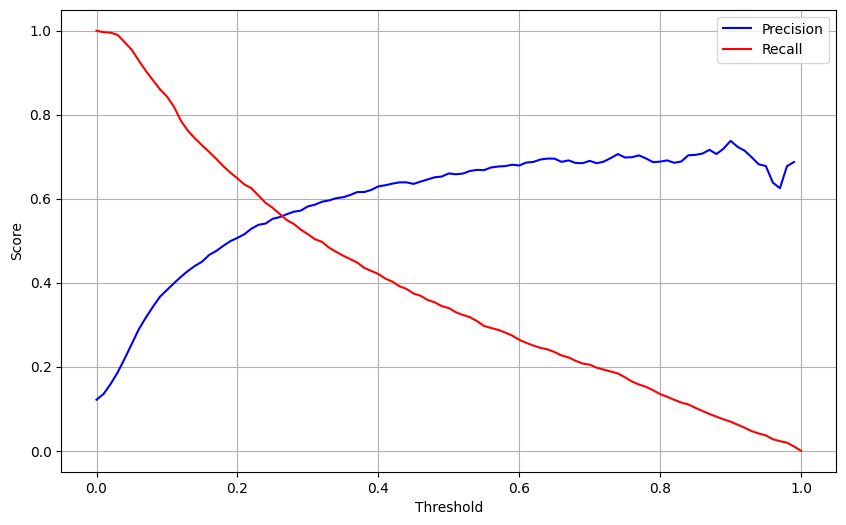

In [29]:
precisions = []
recalls = []

thresholds = np.linspace(0, 1, 101)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
    
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    precisions.append(p)

    r = tp / (tp + fn)
    recalls.append(r)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, recalls, label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [33]:
f1score = {}

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)

    r = tp / (tp + fn)

    f1 = 2 * ((p * r) / (p + r))
    f1score[t] = (f1.round(3))


[key for key, value in f1score.items() if value == max(f1score.values())]

/tmp/ipykernel_1141115/1123112106.py:13: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


[0.22]

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [42]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient = "records")

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient = "records")

    X = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [49]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.y.values
    y_val = df_val.y.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

round(np.std(scores), 3)

0.006

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [50]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(C, np.mean(scores), np.std(scores))


1e-06 0.7014445869766514 0.009444095099939862
0.001 0.8608434190036348 0.007179848457230492
1 0.9058645558975871 0.005652844370349586
